# Automated Data Processing and Clustering Pipeline (for v1v3 only)

In [1]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from helper_functions import *
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from collections import defaultdict

# Modify if the raw data sturcture has been changed
trash_columns = ['id_x_x','sikka_sub_task_operation_x_x','office_x_x','guarantor_x','patient','description','visible_to_patient','primary_insurance_estimate','secondary_insurance_estimate','plan_sr_no','insurance_payment','approved','from_pms_x_x','id_y_x','from_pms_y_x','sikka_sub_task_y_x','sikka_sub_task_operation_y_x','uuid','guarantor_y','office_y_x','fullname','first_name','last_name','address','phone','zip_code','practice','primary_insurance_company_id','profile_picture','date_joined','zip_code_flag','address_comp','final_zip_code','id_x_y','from_pms_x_y','office_x_y','treatment','id_y_y','from_pms_y_y','sikka_sub_task_y_y','sikka_sub_task_operation_y_y','office_y_y','procedure_code_x','procedure_code_description','patient_friendly_description','treatment_id','price','fetched_zip_code_flag','zip_code_verified','fetched_zip_code', 'entry_date', 'tooth_from']
meta_cols = ['provider_x', 'amount', 'treatment_plan_status', 'patient_id', 'city','state_y', 'sikka_provider_id', 'LATITUDE', 'LONGITUDE', 'procedure_age', 'visit_period']
base_cols = ['patient_id', 'procedure_age']

Fill in resource paths

In [2]:
# To be filled (Need to update)
# Path to helper_function.py
helper_function_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py"
# Path to raw full data
full_dataset_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\full_dataset_2.11.csv"
# Path to store rge splitted data (suppose to be an empty file)
Splitted_age_group_output = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test"
# Path to the procedure code mapping excel file
Procedure_code_description_path = r"C:\Frank\UoT 2024-2025\MIE8888 Project\M22\Procedure_Description_Mapping.xlsx"
# Define age group boundary (Neede to update)
Interested_age = 46 # e.g., if input is 31, then we are interested in 30-35; if input is 66, then we are interested in 65-70
# Fill in interested procedure code
target_code='12111'

lower_boundary = Interested_age // 5 * 5
upper_boundary = lower_boundary + 5
age_group_dir = os.path.join(Splitted_age_group_output, f"age_group_v1v3_{lower_boundary}-{upper_boundary}.csv")

## Preprocessing Kmeans and Analysis and Insights (only for the patients who has been shown in the interested age groups)

In [3]:
# Data Loading
full_dataset = full_dataset_path
df = pd.read_csv(full_dataset, encoding="Windows-1252")

# Delete trash columns and clean the data
df = drop_high_nan_columns(df) # Drop columns with more than 50% missing values
df = df.drop(columns = trash_columns) # Drop trash cols
df = merge_columns_with_priority(df,'health_category','procedure_code_category','treatment_category') # merge to get treatment_category with pattern from two category groups
df = df.dropna() # Drop the remaining NA
df, df_dict = object_processing(df) # Project columns dtype = object; For columns containing datetime, convert it to pd.datetime; For other object columns, encode them
df = days_cal_v2(df,'procedure_date','birth_date', 'procedure_age') # procedure_age
df = days_cal_v2(df,'last_visit','first_visit','visit_period') # visit_period
df = one_hot_encode_procedure_and_treatment(df) # # Perform one-hot encoding on the "procedure_code_y" and "treatment_category"

## Store the data loaclly and make a copy for next steps' use
# df.to_csv(r'C:\Frank\UoT 2024-2025\MIE8888 Project\M18\output.csv', index=False)
df_next = df.copy()

# Data Segmentation
patient_versions = df_next.groupby('patient_id').apply(classify_patient).reset_index()
patient_versions.columns = ['patient_id', 'version']
df_next = df_next.merge(patient_versions, on='patient_id')

# Define each dataset version
df_v1 = df_next[df_next['version'] == 'V1']
df_v2 = df_next[df_next['version'] == 'V2']
df_v3 = df_next[df_next['version'] == 'V3']
df_v4 = df_next[df_next['version'] == 'V4']
df_v1_v3 = df_next[df_next['version'].isin(['V1', 'V3'])]

# Split and save each group
df_v1_v3['age_group'] = df_v1_v3['procedure_age'].apply(age_to_group_5_year)
os.makedirs(Splitted_age_group_output, exist_ok=True)
for group_name, group_df in df_v1_v3.groupby('age_group'):
    filename = os.path.join(Splitted_age_group_output, f"age_group_v1v3_{group_name}.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved: {filename}")

C:\Users\frank\AppData\Local\Temp\ipykernel_18440\3721370967.py:3: DtypeWarning: Columns (1,4,10,16,52,85,86,91) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(full_dataset, encoding="Windows-1252")
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:46: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  temp_dt = pd.to_datetime(df[col], errors='raise')
c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\help

Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_0-5.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_10-15.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_15-20.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_20-25.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_25-30.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_30-35.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_35-40.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_40-45.csv
Saved: C:\Frank\UoT 2024-2025\MIE8888 Project\M23\Split dataframe in 5 years v1v3_test\age_group_v1v3_45-5

In [4]:
# Select relevant columns and store as df_subset
procedure_cols = [col for col in df_next.columns if col.startswith('procedure_code_y_') or col.startswith('treatment_category_')]
df_subset = df_next[base_cols + procedure_cols].copy()
df_subset['procedure_age'] = df_subset['procedure_age'].astype(int) # procedure_age to int

# Melt one-hot to long format
df_long = df_subset.melt(id_vars=['patient_id', 'procedure_age'], value_vars=procedure_cols, var_name='procedure_code', value_name='occurred')
df_long = df_long[df_long['occurred'] == 1]
df_long['feature'] = df_long['procedure_code'] + '_age' + df_long['procedure_age'].astype(str)
# by version of June 1st, there are 665,030 true occured results in df_long

# Patients in the interested age group:
df_test = df_long.loc[(df_long['procedure_age'] >= lower_boundary) & (df_long['procedure_age'] < upper_boundary)]
unique_patient = df_test['patient_id'].unique()

# Store the historical and future dataset for these patient
filtered_df_hist = df_long[(df_long['patient_id'].isin(unique_patient)) & (df_long['procedure_age'] < lower_boundary)]
filtered_df_fut = df_long[(df_long['patient_id'].isin(unique_patient)) & (df_long['procedure_age'] >= upper_boundary)]

# Pivot to wide format
df_hist = filtered_df_hist.groupby(['patient_id', 'feature']).size().unstack(fill_value=0).reset_index()
df_fut = filtered_df_fut.groupby(['patient_id', 'feature']).size().unstack(fill_value=0).reset_index()

# Get metadata for wide format
patient_meta = df_next[meta_cols].groupby('patient_id').first().reset_index()
df_hist = pd.merge(patient_meta, df_hist, on='patient_id', how='left').fillna(0)
df_fut = pd.merge(patient_meta, df_fut, on='patient_id', how='left').fillna(0)

The optimal K being select is
4


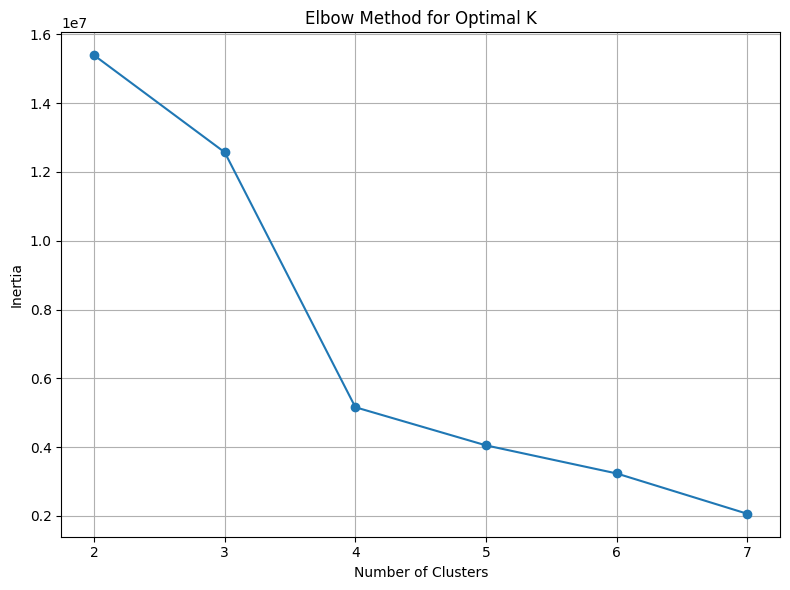

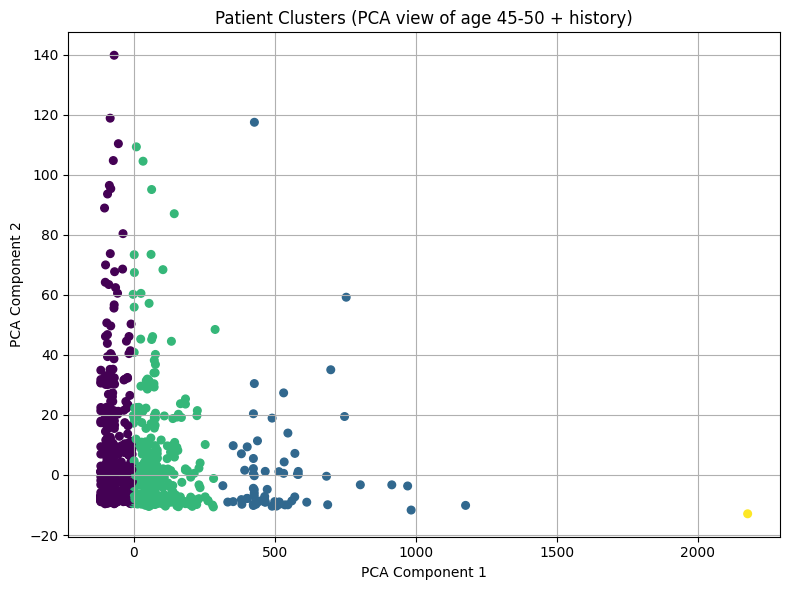

In [ ]:
# Extract binary columns
df_target_age = pd.read_csv(age_group_dir)
binary_cols = [col for col in df_target_age .columns if (col.startswith('procedure_code_y_') or col.startswith('treatment_category_'))]

# Group by patient and aggregate with sum
agg_binary = df_target_age.groupby("patient_id")[binary_cols].sum()

# Combine each patient's complete treatment history in the past with their current age group treatments
df_combined = pd.merge(agg_binary, df_hist, on='patient_id', how='left')

# Apply Kmeans on combined data
df_cluster_input = kmeans_clustering(df_combined, lower_boundary, upper_boundary, scale=False, silent=True)

### Timelines, Trajectory and Flatten

In [ ]:
# Get full timelines
cluster_patients = {}
cluster_timelines = {}
cluster_number = df_cluster_input['cluster'].unique()
for cluster_id in cluster_number:
    patients = df_cluster_input[df_cluster_input['cluster'] == cluster_id]['patient_id']

    cluster_patients[cluster_id] = patients
    timeline = df_v1_v3[df_v1_v3['patient_id'].isin(patients)]

    timeline_sorted = timeline.sort_values(by=['patient_id', 'procedure_date'])
    cluster_timelines[cluster_id] = timeline_sorted

# Conduct trajectory dictionaries
all_patient_trajectories = {}

for cluster_id, df_cluster in cluster_timelines.items():
    print(f"Conducting trajectory cluster {cluster_id}...")
    
    procedure_cols = [col for col in df_cluster.columns if col.startswith('procedure_code_y_')]
    trajectories = defaultdict(list)

    for _, row in df_cluster.iterrows():
        pid = row['patient_id']
        age = row['procedure_age']
        codes = [col.split('_')[-1] for col in procedure_cols if row[col]]
        for code in codes:
            trajectories[pid].append((age, code))

    all_patient_trajectories[cluster_id] = trajectories


# Flatten
df_proc_timelines = {}   # Flattened trajectories per cluster
top10_per_cluster = {}   # Top 10 procedures per age_bin per cluster

for cluster_id, trajectories in all_patient_trajectories.items():
    print(f"Processing flatten cluster {cluster_id}...")
    
    records = []
    for pid, traj in trajectories.items():
        for age, code in traj:
            age_bin = (int(age) // 5) * 5
            records.append((pid, age, age_bin, code))
    
    df_proc = pd.DataFrame(records, columns=['patient_id', 'age', 'age_bin', 'procedure_code'])
    df_proc_timelines[cluster_id] = df_proc

    # Group by age_bin and procedure, count occurrences
    grouped = df_proc.groupby(['age_bin', 'procedure_code']).size().reset_index(name='count')
    # Get top 10 procedures per age_bin
    top10 = grouped.groupby('age_bin').apply(lambda g: g.sort_values(by='count', ascending=False).head(10)).reset_index(drop=True)
    top10_per_cluster[cluster_id] = top10

# Popular procedure code for each cluster (basic and non-basic)
table_basic = get_top_procedures_by_cluster(0, df_proc_timelines, Procedure_code_description_path, True, 10)
table_non_basic = get_top_procedures_by_cluster(0, df_proc_timelines, Procedure_code_description_path, False, 10)

In [ ]:
tables = [get_top_procedures_by_cluster(i, df_proc_timelines, Procedure_code_description_path, True, 10) for i in range(optimal_k_global)]

## Key Ouputs

The optimal K being select is
4


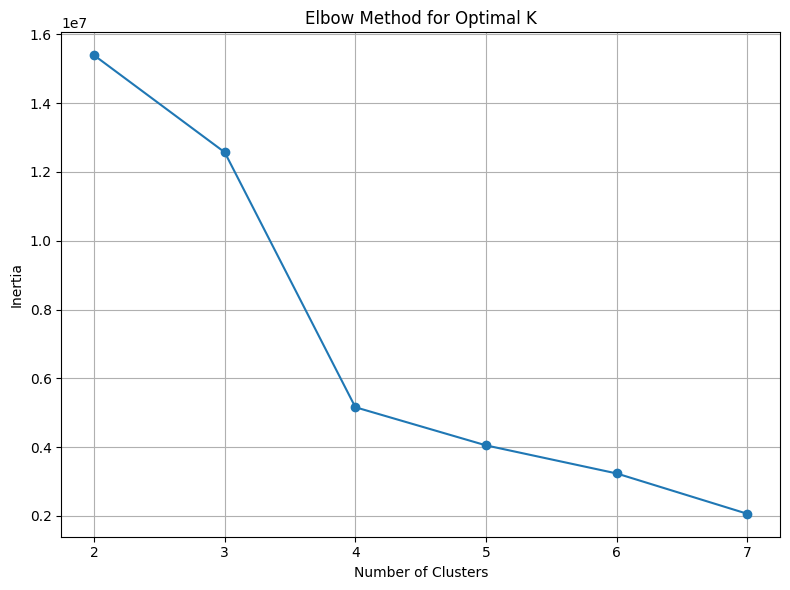

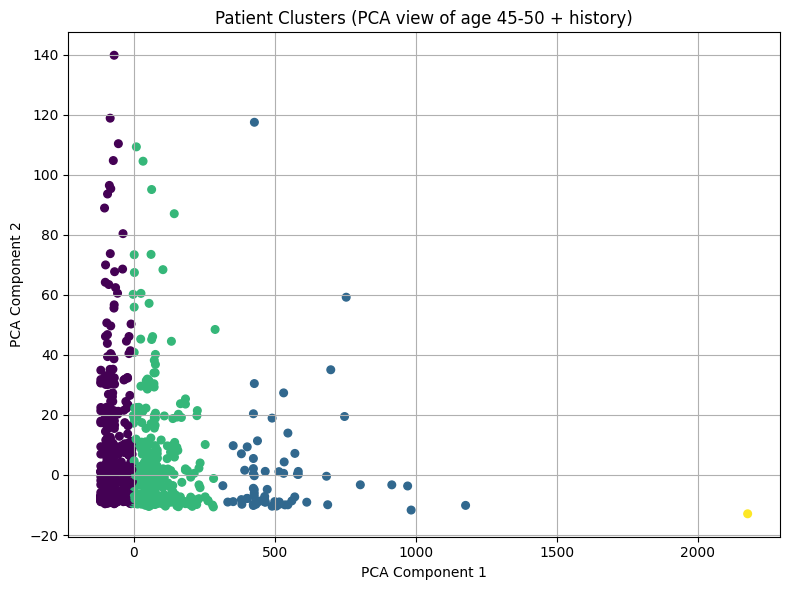

c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:428: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_per_bin = occurrence_per_age.groupby('age_bin')['count'].mean()


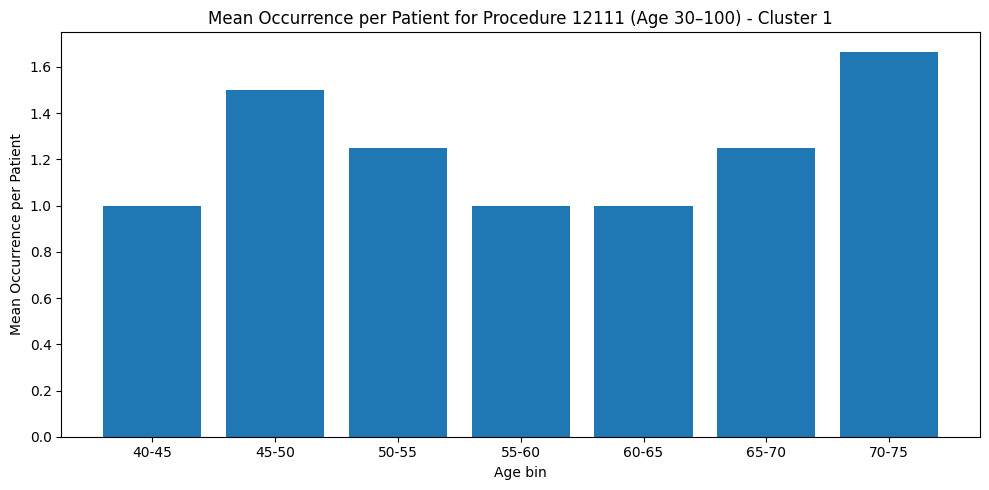

c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:428: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_per_bin = occurrence_per_age.groupby('age_bin')['count'].mean()


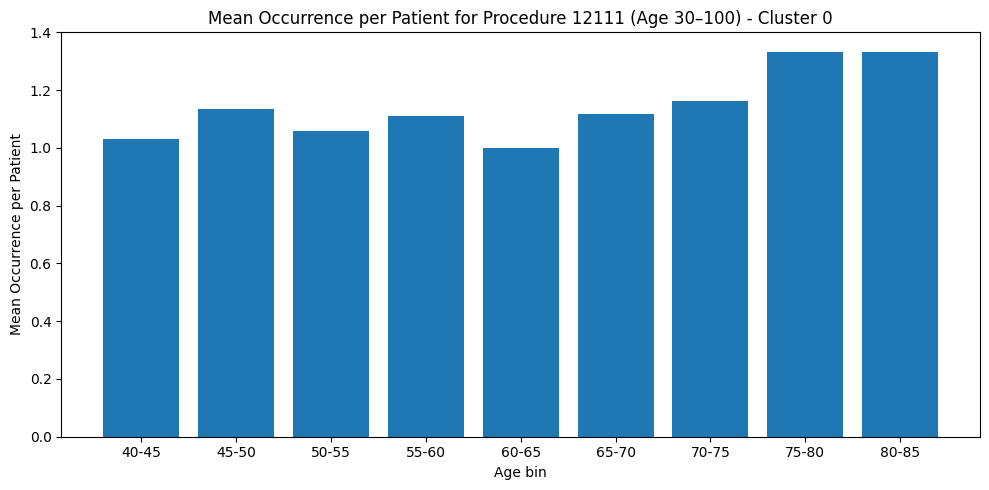

c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:428: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_per_bin = occurrence_per_age.groupby('age_bin')['count'].mean()


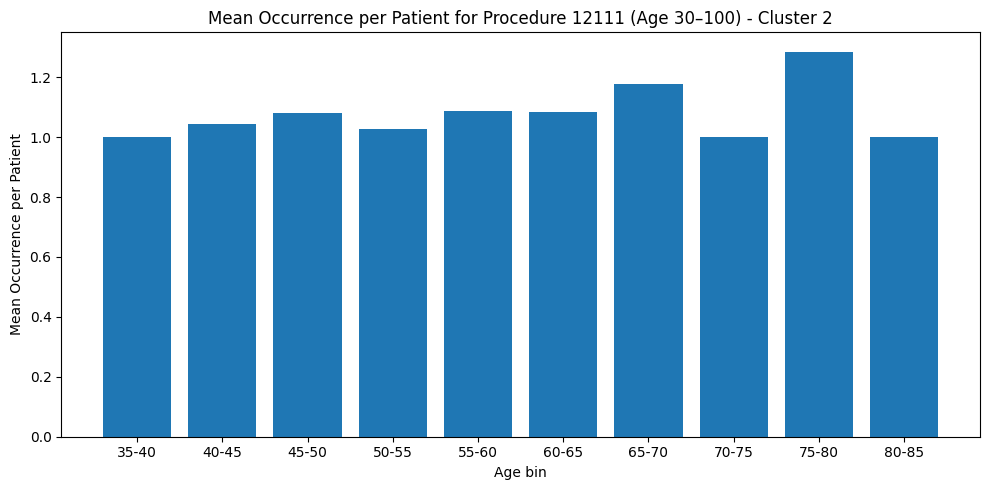

c:\Frank\UoT 2024-2025\MIE8888 Project\SmilePass-2\Recommondation_Trajectory\helper_functions.py:428: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_per_bin = occurrence_per_age.groupby('age_bin')['count'].mean()


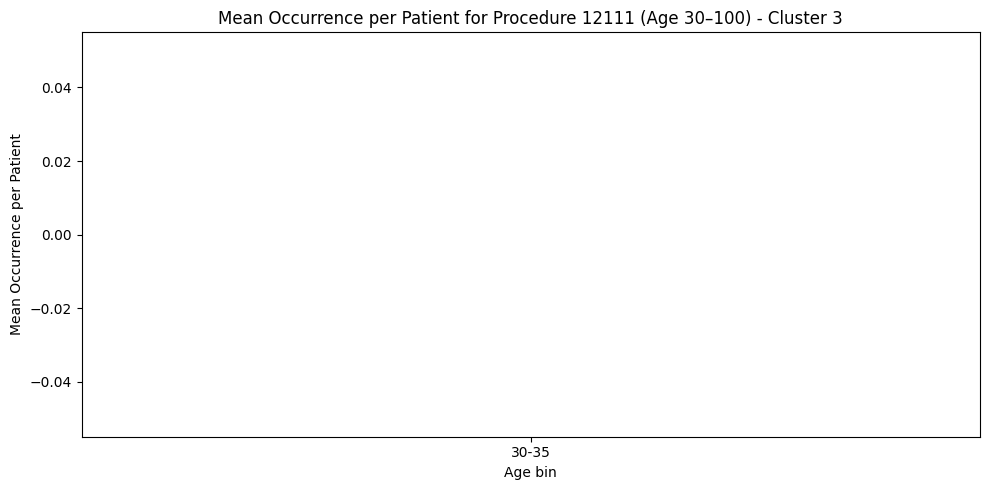

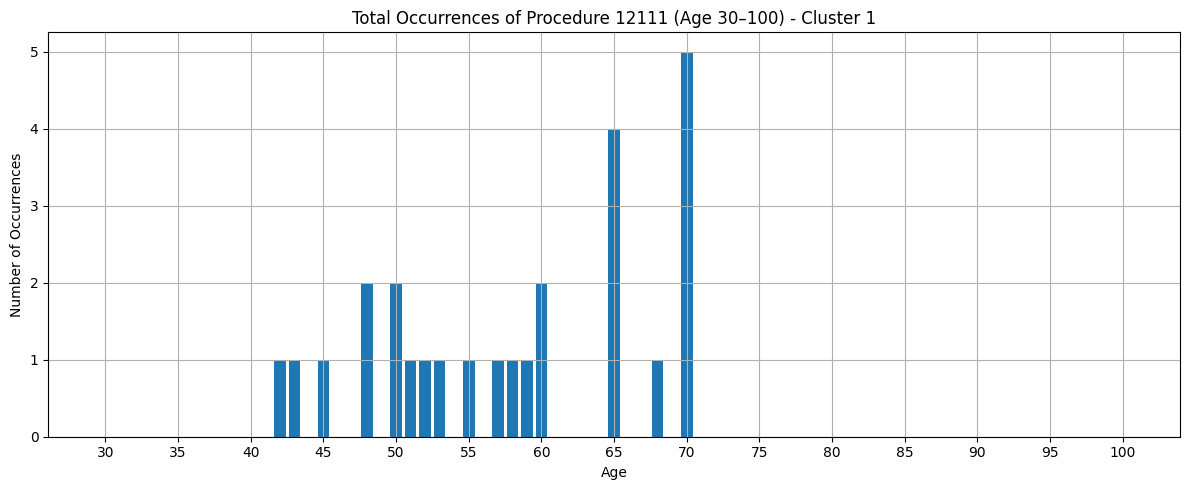

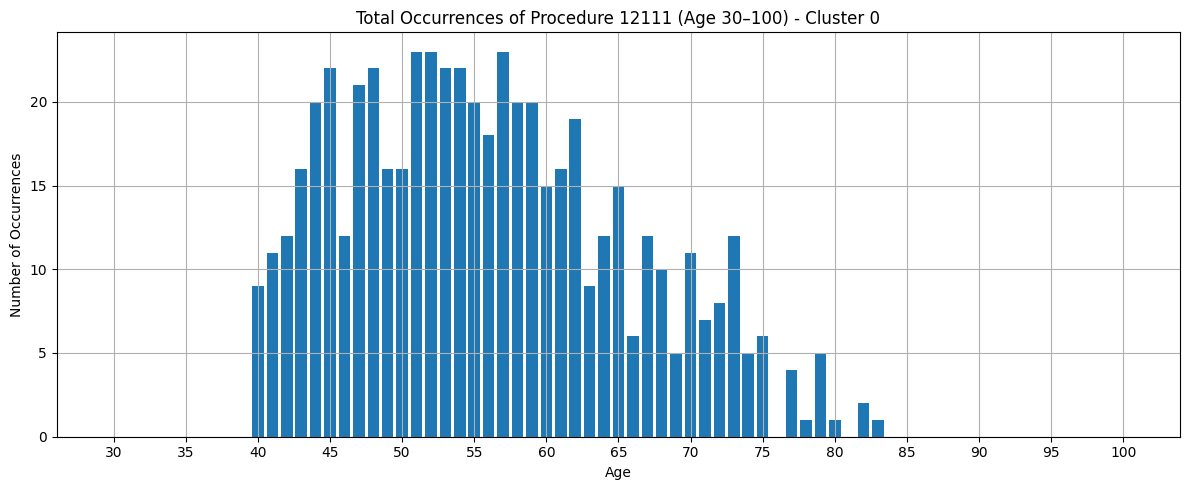

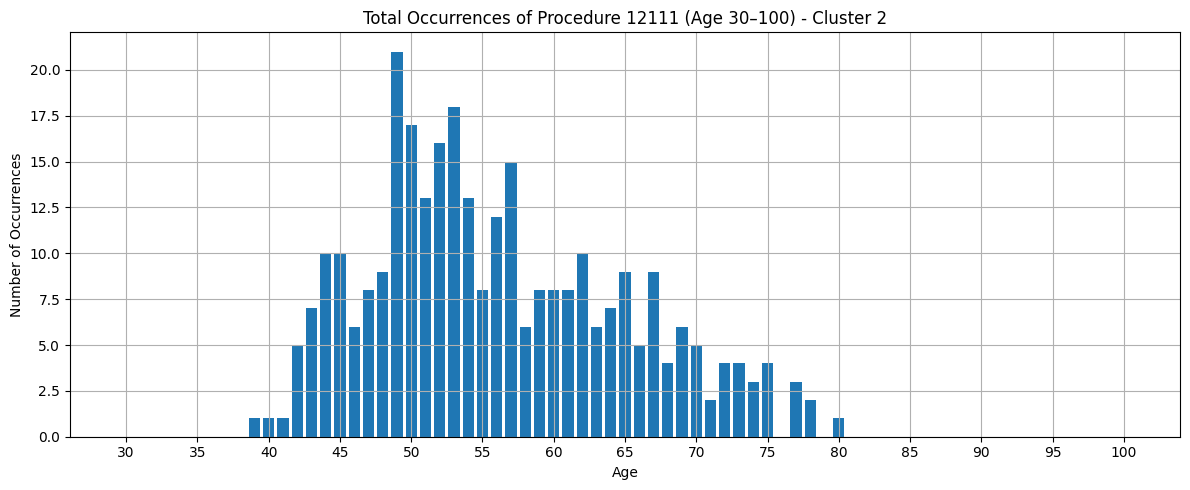

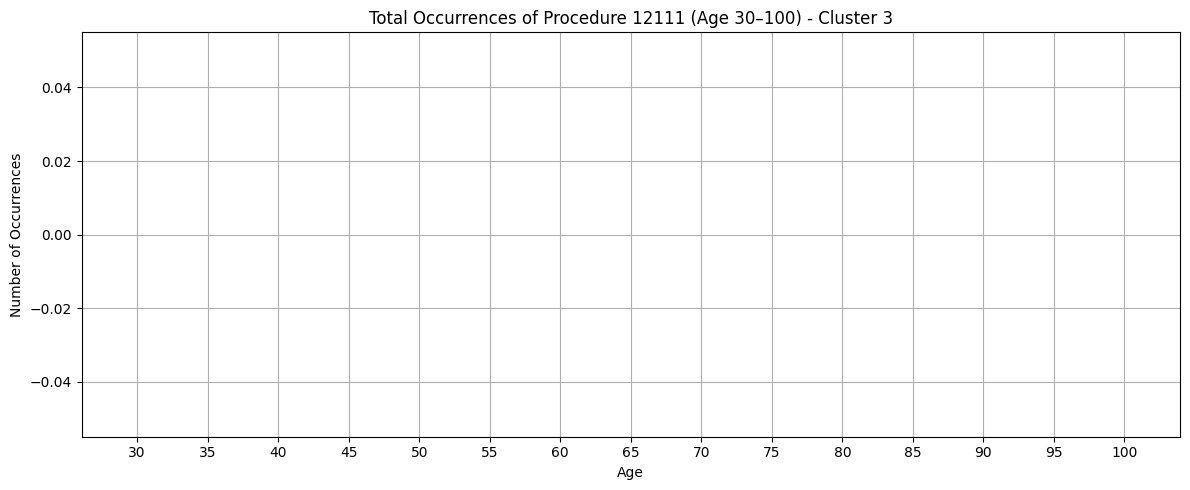

The top popular procedure codes table
  procedure_code  count                                        description
0          11113   6221                 Scaling - Three units (45 minutes)
1          12101   4807  No description found for code: procedure_code_...
2           1204   3917  Examination and Diagnosis, Specific - Examinat...
3           1202   3811  Examination and Diagnosis, Limited Oral, Previ...
4          11107   3770            Polishing - One half unit (7.5 minutes)
5          11117   3373              Scaling - One half unit (7.5 minutes)
6           2144   3258  Radiographs, Regional/Localized, Bitewing - Fo...
7          11114   2992                  Scaling - Four units (60 minutes)
8          11112   2874                   Scaling - Two units (30 minutes)
9          11101   2436          Polishing - One unit of time (15 minutes)

 The top non-basic popular procedure codes table
  procedure_code  count                                        description
0          2

In [ ]:
print('The Kmeans cluster result:')
kmeans_clustering(df_combined, lower_boundary, upper_boundary, scale=False)

print('Procedure code occurence distribution for each group distribution')
plot_procedure_distribution(df_proc_timelines, target_code, average=True)

print('Procedure code mean occurence distribution for each group distribution')
plot_procedure_distribution(df_proc_timelines, target_code, average=False)

print('The top popular procedure codes table')
print(table_basic)

print('The top non-basic popular procedure codes table')
print(table_non_basic)